Goal of this exercise is to predict a property price. First of all, let's load the housing data.

In [1]:
import pandas as pd

def load_data():
    csv_path = "housing.csv"
    return pd.read_csv(csv_path)

In [2]:
housing = load_data()

I found that "Suburb" and "Postalcode" were in a 1:1 relation so I will keep only the latter.

Also, for my purpose, I won't need also "SellerG", "Address" (I can use latitude and longitude instead), "Method" (again, I am trying to predict only the price), "CouncilArea" (I would like to use the suburb as geographical unit) and "Regionname" (it is an aggregation of postal codes).

"Bathroom" is not a selling point, as well the "YearBuilt" (which has also a lot of null values).

"Landsize" and "BuildingArea" are also plagued by empty values and I don not honestly understand the correlation between them: I was expecting the former to be greater than the latter but they are in all the possible correlations.

I am not sure about "Date", since I am trying to predict the price without any regards to the purchase date. For this purpose it is not really useful.

For these reasons, they add more noise than information, so will drop them too.

In [3]:
housing.drop(['Suburb', 'Address', 'Regionname', 'Method', 'SellerG', 'CouncilArea', 'Lattitude', 'Longtitude', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Date'], inplace=True, axis=1)

Since I want to predict prices, if a row does not carry any price, it is pointless to keep it.

In [4]:
housing.dropna(subset=['Price'], inplace=True, axis=0)

Let's now check the remaining columns with null values:

In [5]:
emptyValues = housing.isnull().sum()
print(emptyValues[emptyValues > 0])

Distance            1
Postcode            1
Bedroom2         6441
Propertycount       3
dtype: int64


I think I will fix these columns in this way:
* Distance, PostCode and Propertycount have a few rows each with missing values. Will drop those rows.
* Bedroom2 is scraped from other sources, so no suprises that it is not always filled in. However, I have noticed that there is a certain correlation between the attributes "Rooms" and "Bedroom2". Let's try to visualize it.

In [6]:
housing.dropna(subset=['Distance', 'Postcode', 'Propertycount'], inplace=True, axis=0)

<AxesSubplot:>

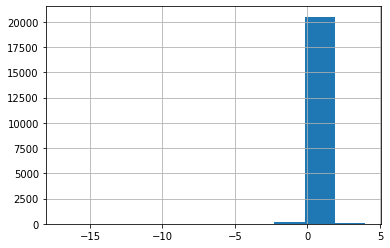

In [7]:
differenceRoomsAndBedrooms = housing['Rooms']-housing['Bedroom2']
differenceRoomsAndBedrooms.hist()

As expected, the number of rooms is basically counting the number of bedrooms: we can therefore simplify even further by dropping also the "Bedroom2" column.

In [8]:
housing.drop(['Bedroom2'], inplace=True, axis=1)


The next attribute to correct is "Type", since right now it is just a plain string.

I will apply a one hot encoder to it, so that it will generate three bolean columns.

In [9]:
import pandas as pd

encondedType = pd.get_dummies(housing.Type)
housing = pd.concat([housing, encondedType], axis=1)
housing.drop(['Type'], inplace=True, axis=1)
housing.head()

,Rooms,Price,Distance,Postcode,Propertycount,h,t,u
1,2,1480000.0,2.5,3067.0,4019.0,1,0,0
2,2,1035000.0,2.5,3067.0,4019.0,1,0,0
4,3,1465000.0,2.5,3067.0,4019.0,1,0,0
5,3,850000.0,2.5,3067.0,4019.0,1,0,0
6,4,1600000.0,2.5,3067.0,4019.0,1,0,0


After looking into the scattered plot for Price and Rooms, I noticed a fewe weird points with 11 or more rooms:

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

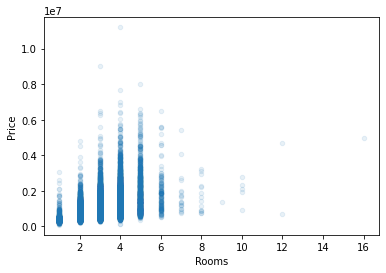

In [10]:
housing.plot(kind="scatter", x="Rooms", y="Price", alpha=0.1)

I assume then that my model will not predict prices for houses with 11 or more rooms, therefore I will drop those rows:

In [11]:
index = housing[housing['Rooms'] >= 11].index
housing.drop(index, inplace=True)

Another improvement we could make is to remove price outliers, especially those rows with a price greater than 8M:

In [12]:
index = housing[housing['Price'] > 8000000].index
housing.drop(index, inplace=True)

Now it is time to prepare training set and test set; I will split them in 80-20 ratio and prepare also the training feature and the corresponding target prices.

In [13]:
from sklearn.model_selection import train_test_split

training_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
training_housing_features = training_set.drop('Price', axis=1)
training_housing_prices = training_set['Price'].copy()
test_housing_features = test_set.drop('Price', axis=1)
test_housing_prices = test_set['Price'].copy()

First attempt of linear regression by using SVD:

In [14]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(training_housing_features, training_housing_prices)

LinearRegression()

Let's now check for the SVD linear regression performs against the test set:

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

test_housing_predictions = linear_regression.predict(test_housing_features)
linear_regression_mse = mean_squared_error(test_housing_prices, test_housing_predictions)
linear_regression_rmse = np.sqrt(linear_regression_mse)
print(str(linear_regression_rmse))

493697.4783453057


['linear_regression.model']

Well, the error is around 0.5M, quite a lot!

Perhaps SVD was overfitting the training set and we might be able to achieve a better result by using a regularized linear model.

Since regularized linear models are using SGD, we need first to scale the training set by using the StandardScaler. The test set will run through the same scaler but without participating in deciding mean and standard deviation.

In [16]:
from sklearn.preprocessing import StandardScaler

feature_scaler = (StandardScaler()).fit(training_housing_features)
scaled_training_housing_features = feature_scaler.transform(training_housing_features)

price_scaler = (StandardScaler()).fit(training_housing_prices.values.reshape(-1,1))
scaled_training_housing_prices = price_scaler.transform(training_housing_prices.values.reshape(-1,1))

scaled_test_housing_features = feature_scaler.transform(test_housing_features)
scaled_test_housing_prices = price_scaler.transform(test_housing_prices.values.reshape(-1,1))

Let's now use ElasticNet with different values for its parameters alpha and l1_ratio

In [22]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np

for current_l1_ratio in [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]:
    for current_alpha in [0.01, 0.1, 1, 10]:
        elastic_net = ElasticNet(alpha=current_alpha, l1_ratio=current_l1_ratio)
        elastic_net.fit(scaled_training_housing_features, scaled_training_housing_prices)
        
        scaled_test_housing_predictions = elastic_net.predict(scaled_test_housing_features)
        test_housing_predictions = price_scaler.inverse_transform(scaled_test_housing_predictions)
        
        elastic_net_mse = mean_squared_error(test_housing_prices, test_housing_predictions)
        elastic_net_rmse = np.sqrt(elastic_net_mse)
        print('l1_ratio = ' + str(current_l1_ratio) + '; alpha = ' + str(current_alpha) + '; rmse = ' + str(elastic_net_rmse))

l1_ratio = 0.1; alpha = 0.01; rmse = 493909.0782773401
l1_ratio = 0.1; alpha = 0.1; rmse = 499153.5822274606
l1_ratio = 0.1; alpha = 1; rmse = 570260.6843483079
l1_ratio = 0.1; alpha = 10; rmse = 646400.5614867874
l1_ratio = 0.5; alpha = 0.01; rmse = 494139.2571191287
l1_ratio = 0.5; alpha = 0.1; rmse = 506926.582014256
l1_ratio = 0.5; alpha = 1; rmse = 646400.5614867874
l1_ratio = 0.5; alpha = 10; rmse = 646400.5614867874
l1_ratio = 0.7; alpha = 0.01; rmse = 494274.1091233907
l1_ratio = 0.7; alpha = 0.1; rmse = 512588.88070165383
l1_ratio = 0.7; alpha = 1; rmse = 646400.5614867874
l1_ratio = 0.7; alpha = 10; rmse = 646400.5614867874
l1_ratio = 0.9; alpha = 0.01; rmse = 494422.4265241767
l1_ratio = 0.9; alpha = 0.1; rmse = 519802.22890113504
l1_ratio = 0.9; alpha = 1; rmse = 646400.5614867874
l1_ratio = 0.9; alpha = 10; rmse = 646400.5614867874
l1_ratio = 0.95; alpha = 0.01; rmse = 494461.65480079455
l1_ratio = 0.95; alpha = 0.1; rmse = 521877.70392569894
l1_ratio = 0.95; alpha = 1; rm

The first combination of parameter values is providing the lowest rmse but still it is not as good as SVD.

Just out of curiosity, let's check what a polynomial regression can provide in terms of RMSE:

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

for current_degree in range(2, 7):
    polynomial_features = PolynomialFeatures(degree=current_degree, include_bias=False)
    polynomial_training_housing_features = polynomial_features.fit_transform(training_housing_features)

    polynomial_linear_regression = LinearRegression()
    polynomial_linear_regression.fit(polynomial_training_housing_features, training_housing_prices)

    polynomial_test_housing_features = polynomial_features.fit_transform(test_housing_features)
    polynomial_test_housing_predictions = polynomial_linear_regression.predict(polynomial_test_housing_features)
    polynomial_linear_regression_mse = mean_squared_error(test_housing_prices, polynomial_test_housing_predictions)
    polynomial_linear_regression_rmse = np.sqrt(polynomial_linear_regression_mse)
    print('Degree = ' + str(current_degree) + '; rmse = ' + str(polynomial_linear_regression_rmse))


Degree = 2; rmse = 428659.0393608111
Degree = 3; rmse = 420387.4406687108
Degree = 4; rmse = 452563.13080652914
Degree = 5; rmse = 484350.2588487776
Degree = 6; rmse = 593672.337002067


Interesting! We have found a better result with a 3rd degree polynomial regressor.

I want now to check with decision trees what we can get as accuracy by varying the max depth:

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

for current_max_depth in [2, 3, 5, 7, 10, 15, 20]:
    for current_min_samples_leaf in [10, 100, 500, 1000]:
        decision_tree_regression = DecisionTreeRegressor(max_depth=current_max_depth, min_samples_leaf=current_min_samples_leaf)
        decision_tree_regression.fit(training_housing_features, training_housing_prices)

        decision_tree_test_housing_predictions = decision_tree_regression.predict(test_housing_features)
        decision_tree_mse = mean_squared_error(test_housing_prices, decision_tree_test_housing_predictions)
        decision_tree_rmse = np.sqrt(decision_tree_mse)
        print('Depth = ' + str(current_max_depth) + '; leaf samples = ' + str(current_min_samples_leaf) + '; rmse = ' + str(decision_tree_rmse))

Depth = 2; leaf samples = 10; rmse = 539536.7163010602
Depth = 2; leaf samples = 100; rmse = 539536.7163010602
Depth = 2; leaf samples = 500; rmse = 539536.7163010602
Depth = 2; leaf samples = 1000; rmse = 539536.7163010602
Depth = 3; leaf samples = 10; rmse = 476271.94958388223
Depth = 3; leaf samples = 100; rmse = 476271.94958388223
Depth = 3; leaf samples = 500; rmse = 476271.94958388223
Depth = 3; leaf samples = 1000; rmse = 478102.21113383
Depth = 5; leaf samples = 10; rmse = 392402.67250488355
Depth = 5; leaf samples = 100; rmse = 391885.97032805916
Depth = 5; leaf samples = 500; rmse = 408727.9491984316
Depth = 5; leaf samples = 1000; rmse = 434547.0483493206
Depth = 7; leaf samples = 10; rmse = 368895.38209984085
Depth = 7; leaf samples = 100; rmse = 369561.3829098239
Depth = 7; leaf samples = 500; rmse = 403162.75761297124
Depth = 7; leaf samples = 1000; rmse = 433574.86535895255
Depth = 10; leaf samples = 10; rmse = 340809.7159311701
Depth = 10; leaf samples = 100; rmse = 361

It looks like that with a depth = 20 and min_samples_leaf = 10 we got a very good result. What about RandomForestRegressor?

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

for current_n_estimators in [10, 100, 500, 1000]:
    random_forest_regression = RandomForestRegressor(n_estimators=current_n_estimators, max_depth=20, min_samples_leaf=10, n_jobs=-1)
    random_forest_regression.fit(training_housing_features, training_housing_prices)

    random_forest_test_housing_predictions = random_forest_regression.predict(test_housing_features)
    random_forest_mse = mean_squared_error(test_housing_prices, random_forest_test_housing_predictions)
    random_forest_rmse = np.sqrt(random_forest_mse)
    print('N. estimators = ' + str(current_n_estimators) + '; rmse = ' + str(random_forest_rmse))

N. estimators = 10; rmse = 336913.1443992009
N. estimators = 100; rmse = 334807.7431563771
N. estimators = 500; rmse = 334132.2846128307
N. estimators = 1000; rmse = 334029.190395628


With 100 estimators the result has even improved!